# Adding PSF convolution to all sources in `castor_etc`

Isaac Cheng - August 2023

**EDIT (2023-09-18): this notebook has been updated to reflect `castor_etc v1.2.1`.**

This notebook is to accompany
[pull request #11](https://github.com/CASTOR-telescope/ETC/pull/11), which adds PSF
convolution to ALL sources. Moreover, the PSFs are the actual CASTOR PSFs, so we are no
longer assuming a simple Gaussian PSF. This update actually also simplifies calculations
in the backend, since we are using the same method (i.e., supersampling apertures) for all
sources.

This update also makes the photometry ETC truly 100% pixel-based. At first, our point
source calculations were not truly pixel based (i.e., you could change the source weights
and nothing would happen, as noted in the info message). With the previous PR
([#10](https://github.com/CASTOR-telescope/ETC/pull/10)), *none* of the sources were truly
pixel based (I know... -_-). But now, *all* sources are completely pixel-based! If
the user changes, e.g., some of the pixels in the point source array, it *will* affect
calculations!

Note that we are still using the fraction of flux contained within the aperture to do our
photometry calculations, except now our source weights give the fraction of flux contained
within each pixel directly. An enclosed flux fraction of 100% corresponds to the magnitude
of the source that the user set. So if I normalize a spectrum to, say, an AB magnitude of
25, then this AB magnitude will be the AB magnitude of the source if 100% of its flux was
contained within the aperture. If I choose an aperture that only contains 50% of the flux,
however, the effective AB magnitude will be dimmer.

As a final note, all PSF convolutions are done at 20x the resolution of the telescope's
detectors (following the resolution of the default PSF files, also see
[make_oversampled_psfs.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/master/make_oversampled_psfs.ipynb)).
Only after convolution do we bin the arrays down to the proper resolution.

This notebook is based on the
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb) notebook.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

## Optimal aperture examples

We assume the PSFs provided by the user are sufficiently large to enclose roughly 100% of
the flux from the source, and we compare the flux contained within the aperture to the sum
of the PSF values.

To generate our source weights, we convolve a single bright pixel (i.e., 1 pixel at the
supersampled resolution) with the (supersampled) PSF, then we apply an aperture mask and
bin the arrays down to the proper resolution. I've checked that this gives the same result
as manually slicing the PSF image to the extent of the aperture (the former method is just
easier and gives more flexibility).

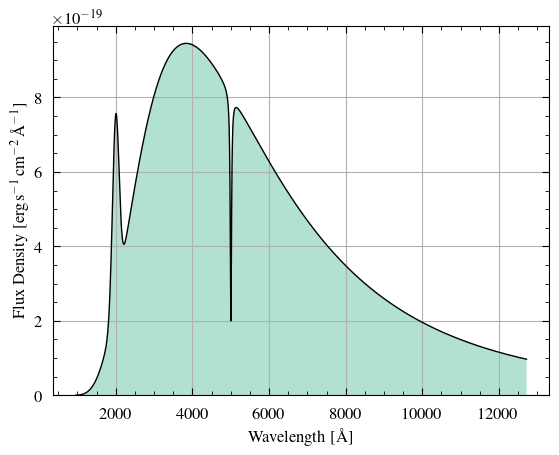

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



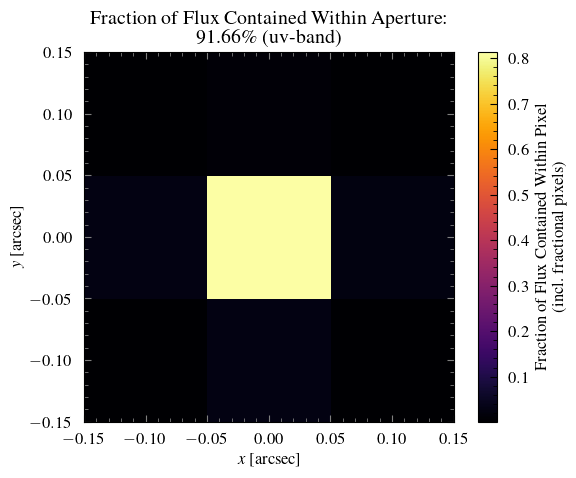

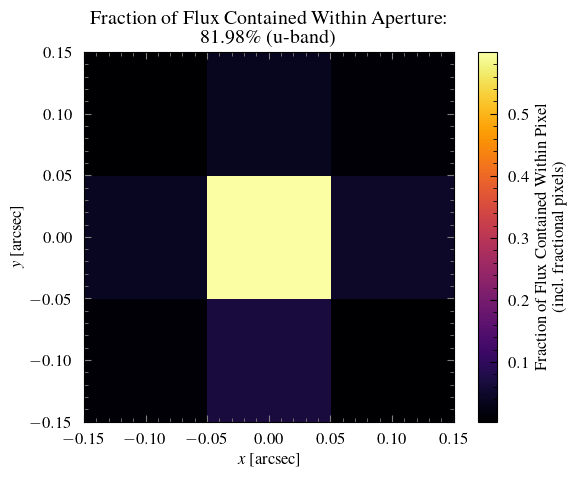

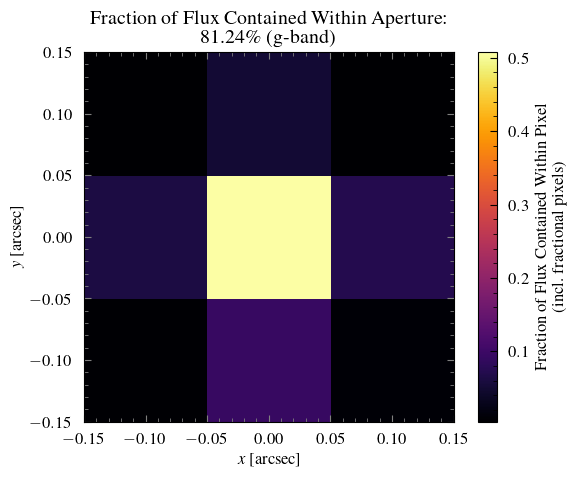

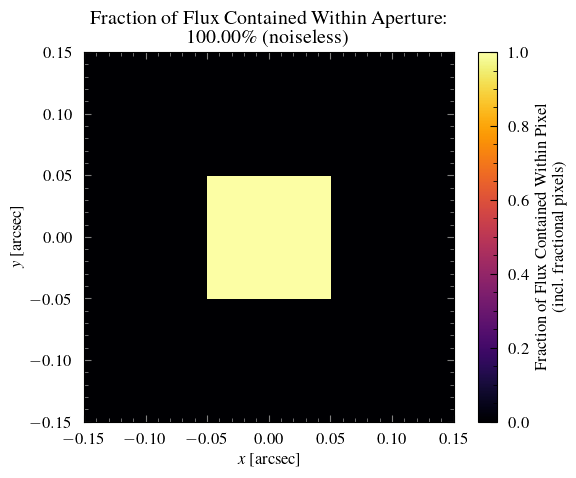

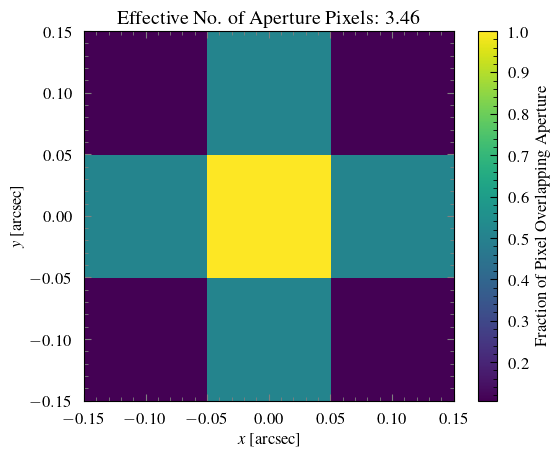

INFO: Fraction of flux within aperture in uv-band = 0.9166222244569432
INFO: Fraction of flux within aperture in u-band = 0.8197924990816455
INFO: Fraction of flux within aperture in g-band = 0.8124391997241297

Time (s) required to reach SNR=10 in uv-band 1004.2049912258641
SNR achieved in t=1004.2049912258641 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 233.72366944084808
SNR achieved in t=233.72366944084808 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 124.83491711146208
SNR achieved in t=124.83491711146208 seconds in g-band 10.0



In [2]:
# Same as the 1st example in
# [getting_started_photometry.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/a5357452875033a6e4e28f001d55210871c02cfa/getting_started_photometry.ipynb)

MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_optimal_aperture(factor=1.4)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Now what if we change the source weights? For example, let's double the flux through the
brightest pixel.

(Note that this leads to an encircled energy > 100%, which is not physical. This is just
to demonstrate how changing the source weights *will* affect calculations, even for point
sources.)

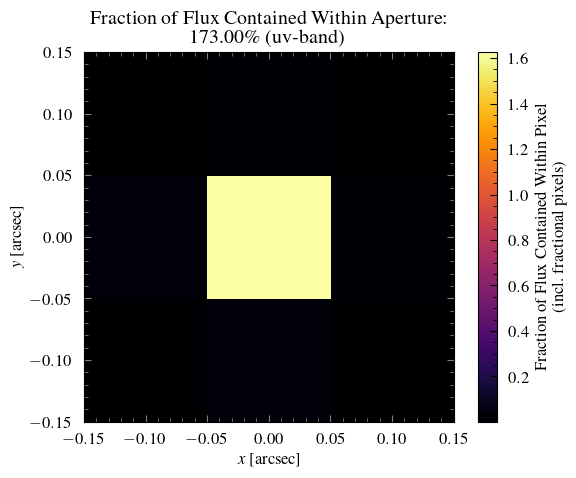

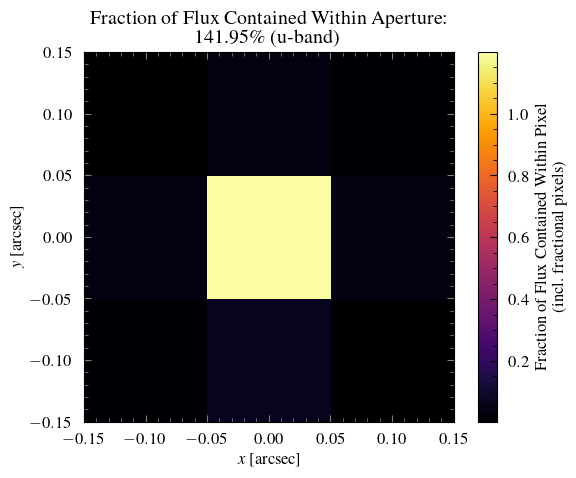

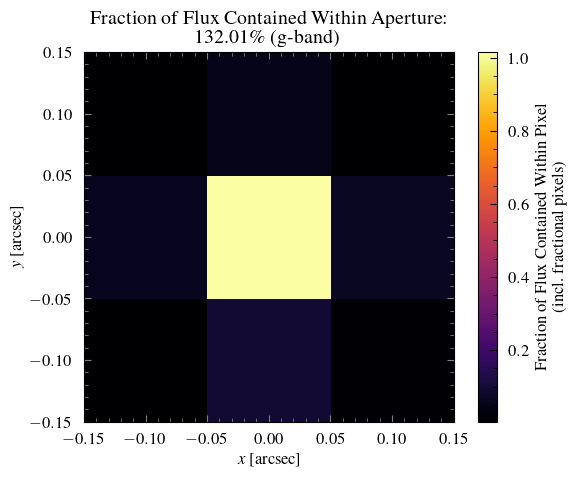

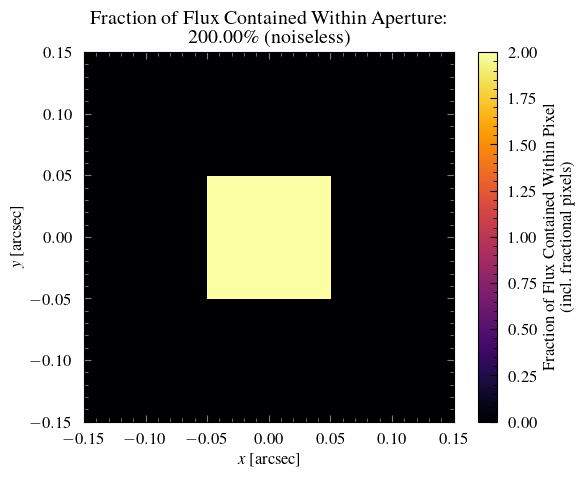

INFO: Fraction of flux within aperture in uv-band = 1.7299606828739467
INFO: Fraction of flux within aperture in u-band = 1.419481912147129
INFO: Fraction of flux within aperture in g-band = 1.3201112075979728

Time (s) required to reach SNR=10 in uv-band 491.29564654546687
SNR achieved in t=491.29564654546687 seconds in uv-band 10.000000000000002

Time (s) required to reach SNR=10 in u-band 131.20240254453606
SNR achieved in t=131.20240254453606 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 72.02069362652934
SNR achieved in t=72.02069362652934 seconds in g-band 9.999999999999998



In [3]:
for band in MyPhot.source_weights:
    # Double flux through brightest pixel
    MyPhot.source_weights[band][
        abs(MyPhot.source_weights[band] - np.nanmax(MyPhot.source_weights[band])) < 1e-15
    ] *= 2
    MyPhot.show_source_weights(band)


TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Elliptical aperture examples

### Point source with elliptical aperture

We recover the same results as those from the optimal aperture when we set the same
parameters.

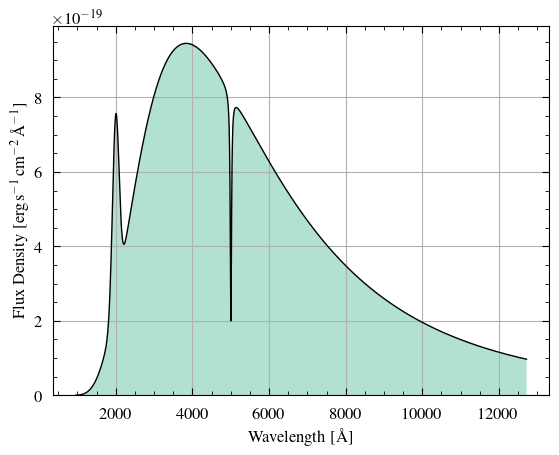

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



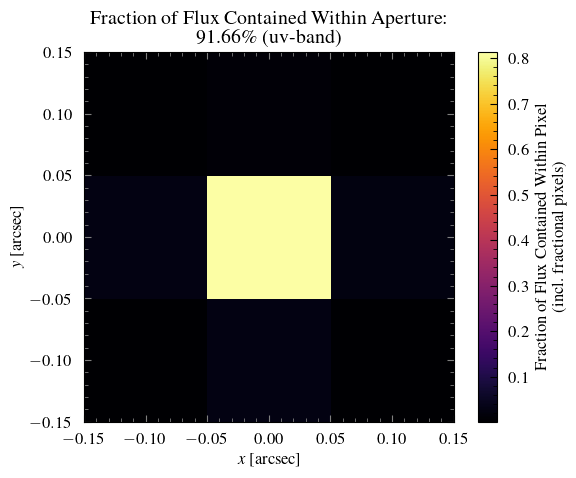

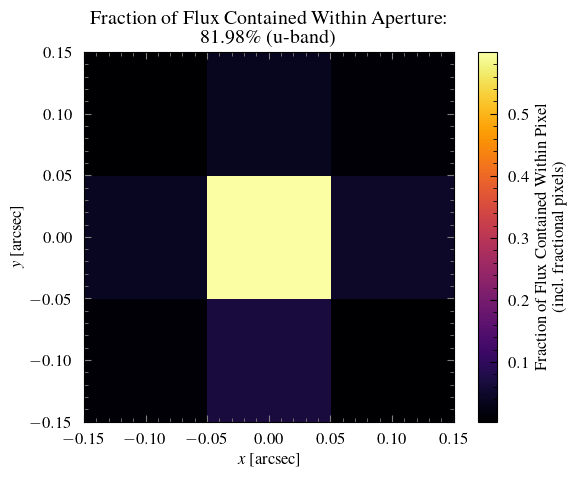

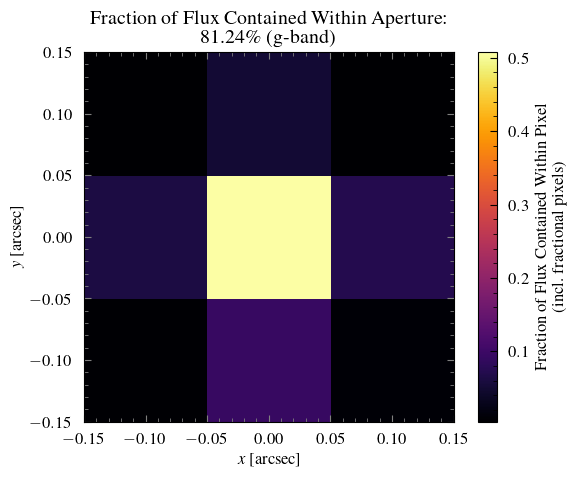

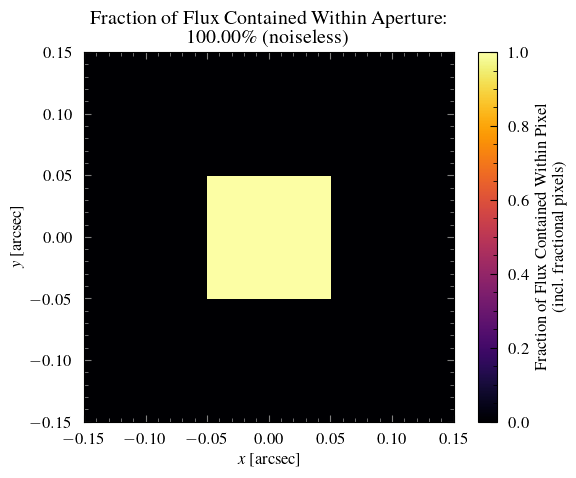

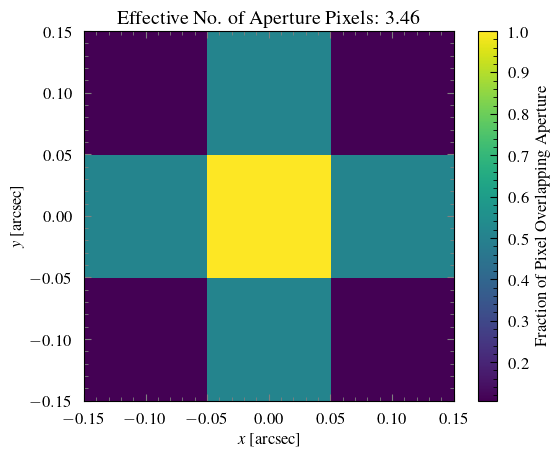

INFO: Fraction of flux within aperture in uv-band = 0.9166222244569432
INFO: Fraction of flux within aperture in u-band = 0.8197924990816455
INFO: Fraction of flux within aperture in g-band = 0.8124391997241297

Time (s) required to reach SNR=10 in uv-band 1004.2049912258641
SNR achieved in t=1004.2049912258641 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 233.72366944084808
SNR achieved in t=233.72366944084808 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 124.83491711146208
SNR achieved in t=124.83491711146208 seconds in g-band 10.0



In [4]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(a=a, b=b, center=[0, 0] * u.arcsec)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Now we use an off-centred elliptical aperture for a point source.

To emphasize, we convolve the (supersampled) PSF with the supersampled aperture, then we
bin the arrays down to the ones shown below. This means that we are *not* simply
convolving the 1 bright pixel shown in the final "noiseless" array. Rather, that final
bright pixel simply means that the single bright pixel generated in the supersampled
source arrays happened to land within the extent of that final pixel.

(Notice the extent of the axes have changed. The centre of the source will always be at
(0,0), and the centre of the aperture will be at the coordinate specified.)

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



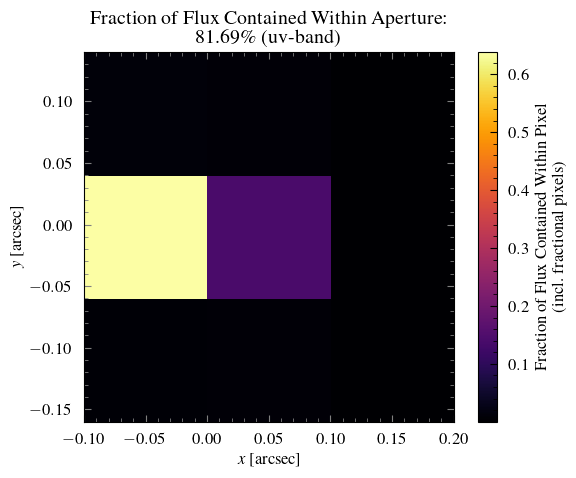

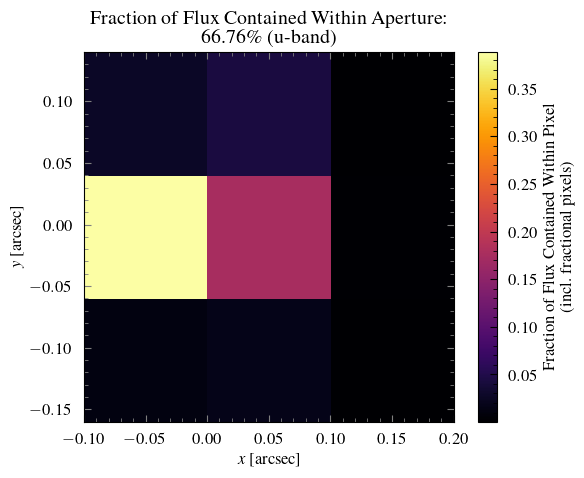

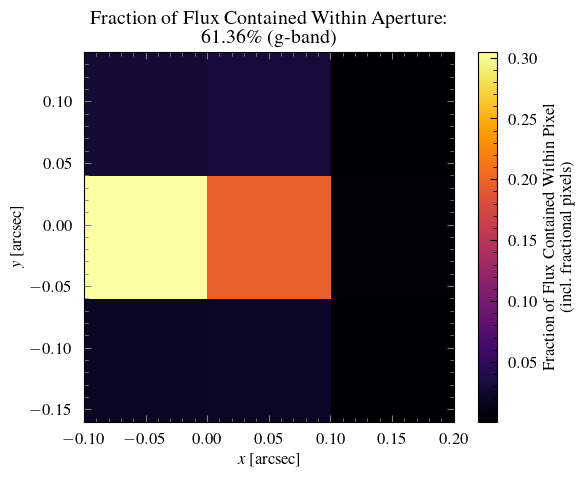

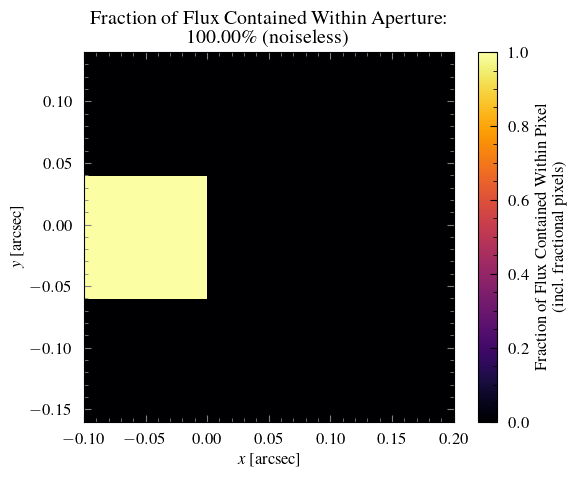

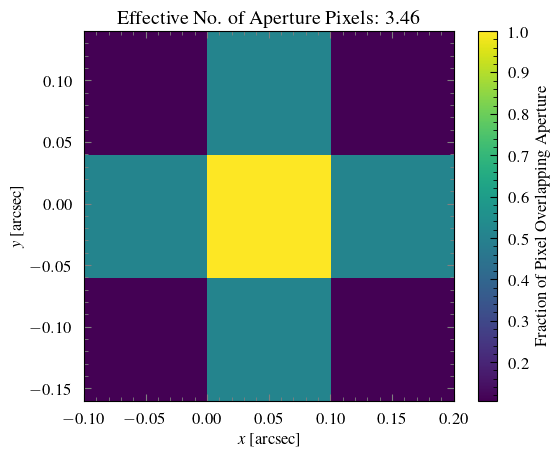

INFO: Fraction of flux within aperture in uv-band = 0.8168825599128458
INFO: Fraction of flux within aperture in u-band = 0.6675636254021523
INFO: Fraction of flux within aperture in g-band = 0.6136158061639145

Time (s) required to reach SNR=10 in uv-band 1149.4304235872837
SNR achieved in t=1149.4304235872837 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 291.3779639184082
SNR achieved in t=291.3779639184082 seconds in u-band 10.000000000000002

Time (s) required to reach SNR=10 in g-band 174.07853527616325
SNR achieved in t=174.07853527616325 seconds in g-band 10.000000000000002



In [5]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(a=a, b=b, center=[0.05, -0.01] * u.arcsec)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with elliptical aperture

Below, we see an aperture the size of the half-light radius enclosing half the light from
the (noiseless) galaxy, as expected.

Since a source's attributes are independent of aperture or telescope, we set the
*noiseless* image to act as the reference flux for the passbands (that *have* been
convolved with their respective PSF). Below, notice how the fraction of flux enclosed in
the same aperture varies depending on the PSF. Only in the noiseless case will an aperture
with dimensions equal to the galaxy's half-light radius enclose 50% of the light from the
source.

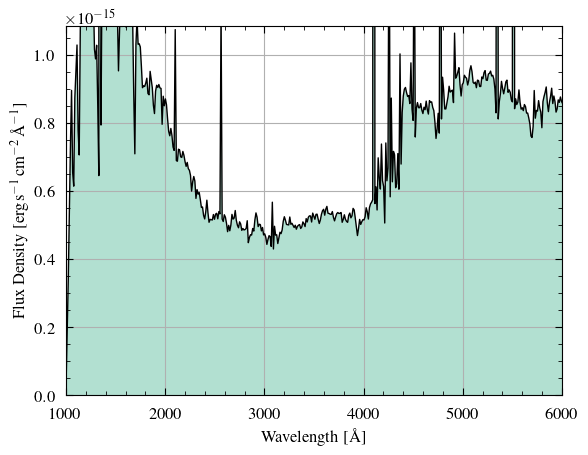

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



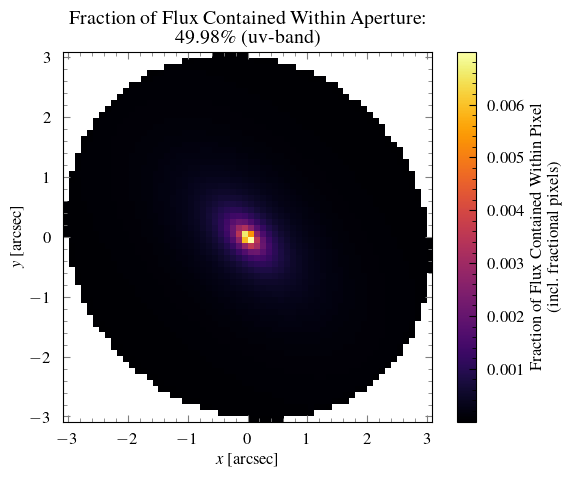

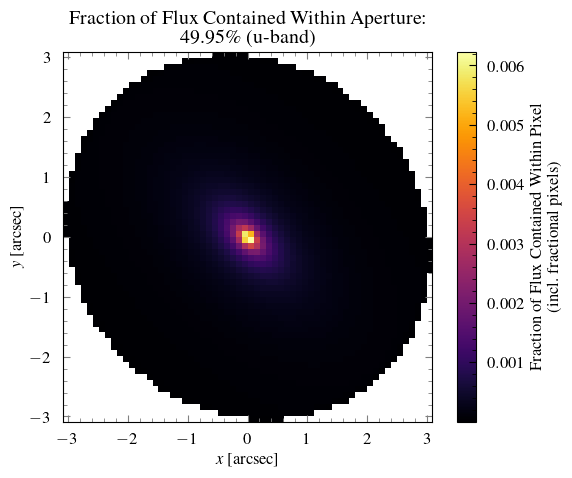

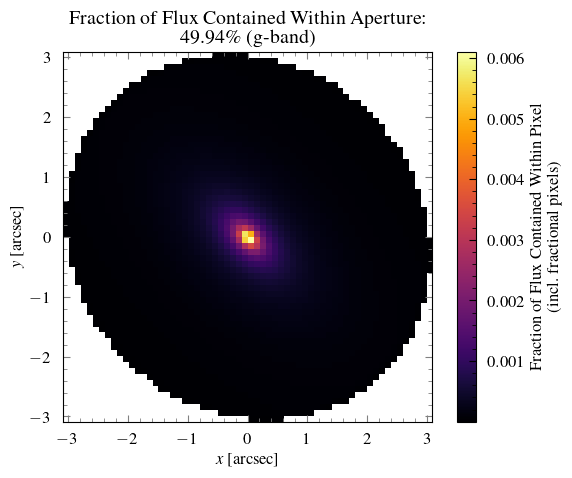

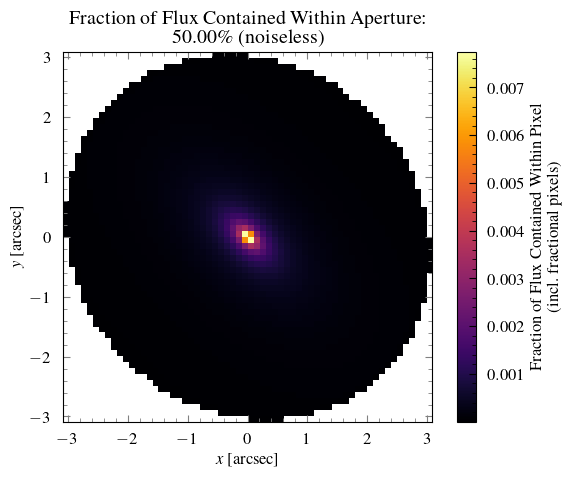

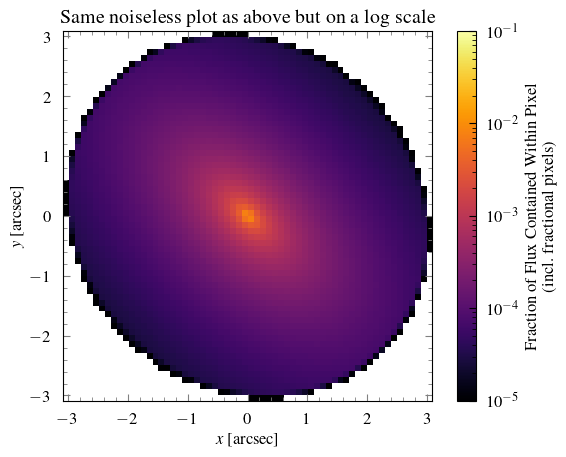

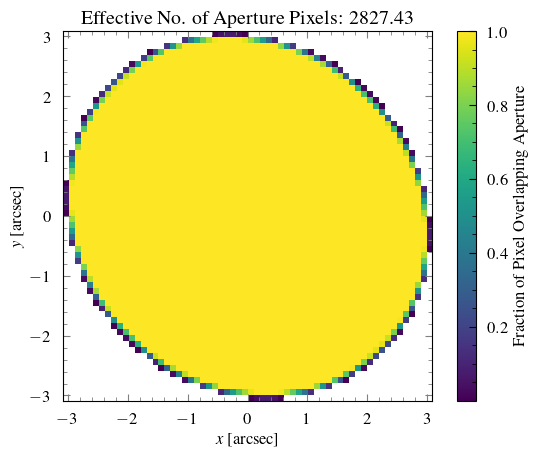

INFO: Fraction of flux within aperture in uv-band = 0.4998422617863919
INFO: Fraction of flux within aperture in u-band = 0.49952589460659946
INFO: Fraction of flux within aperture in g-band = 0.4993686707560313

SNR achieved in t=4321 seconds in uv-band 585.3682124024549
Time (s) required to reach SNR=585.3682124024549 in uv-band 4321.0

SNR achieved in t=4321 seconds in u-band 792.6800093553392
Time (s) required to reach SNR=792.6800093553392 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1708.8170911343268
Time (s) required to reach SNR=1708.8170911343268 in g-band 4320.999999999999



In [6]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=MySource.angle_a,
    b=MySource.angle_b,
    center=[0, 0] * u.arcsec,
    rotation=np.rad2deg(MySource.rotation),
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
fig, ax, img, cbar = MyPhot.show_source_weights(
    "noiseless", norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False
)
ax.set_title("Same noiseless plot as above but on a log scale")
plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

Now we move the aperture off centre and increase its eccentricity.

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



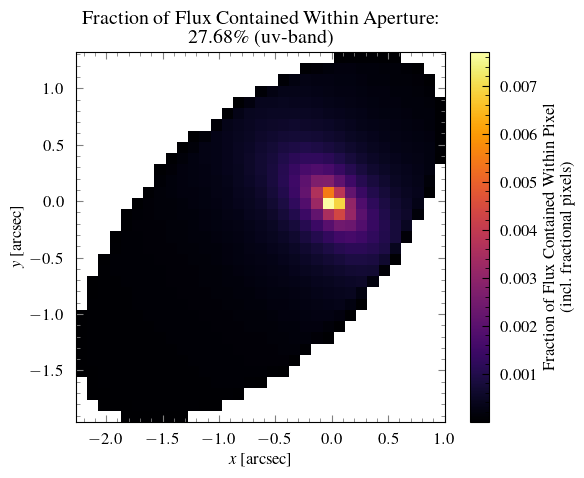

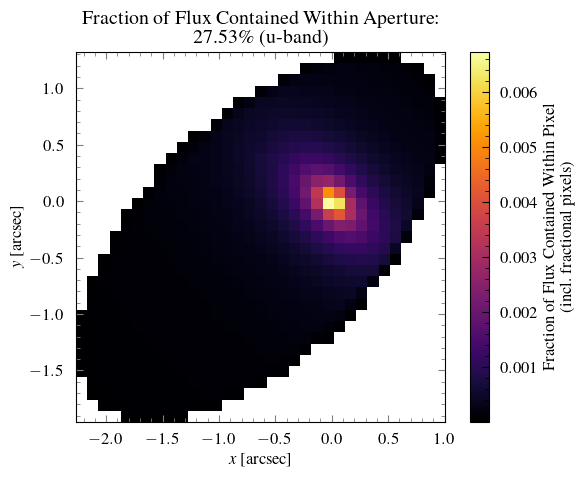

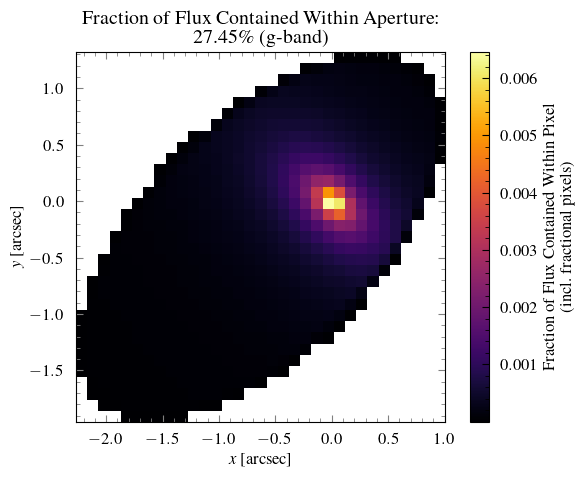

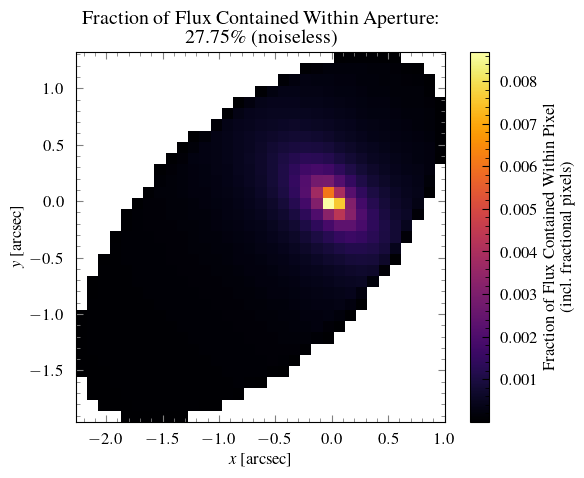

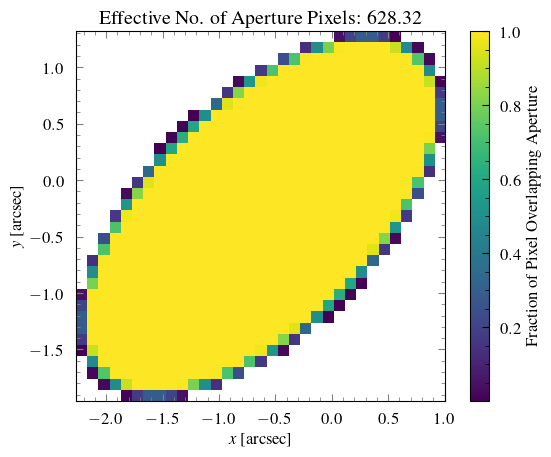

INFO: Fraction of flux within aperture in uv-band = 0.2768260717628078
INFO: Fraction of flux within aperture in u-band = 0.2753223915695728
INFO: Fraction of flux within aperture in g-band = 0.2745401344961097

SNR achieved in t=4321 seconds in uv-band 453.0521676522083
Time (s) required to reach SNR=453.0521676522083 in uv-band 4321.000000000001

SNR achieved in t=4321 seconds in u-band 624.2280161009743
Time (s) required to reach SNR=624.2280161009743 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1351.779257728091
Time (s) required to reach SNR=1351.779257728091 in g-band 4321.000000000001



In [7]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    2 * u.arcsec,
    1 * u.arcsec,
    center=np.array([-0.2, -0.1]) * MySource.angle_a,
    rotation=45,
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with elliptical aperture

We see that an aperture with the same extent as an extended source encloses 100% of its
flux, only in the noiseless case. This is by our definition.

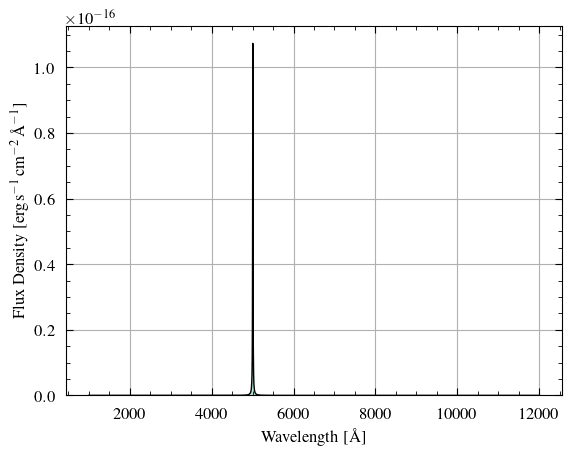

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


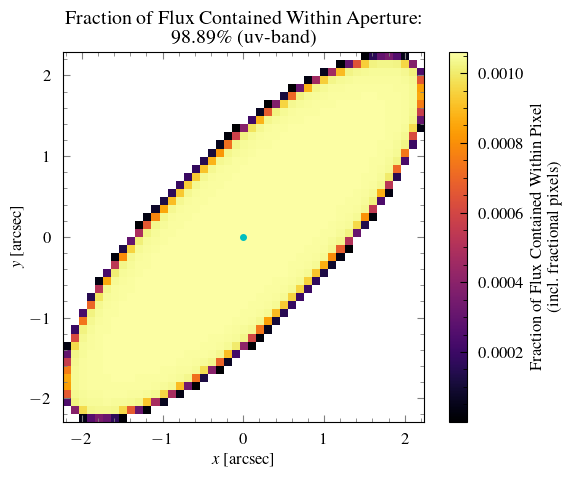

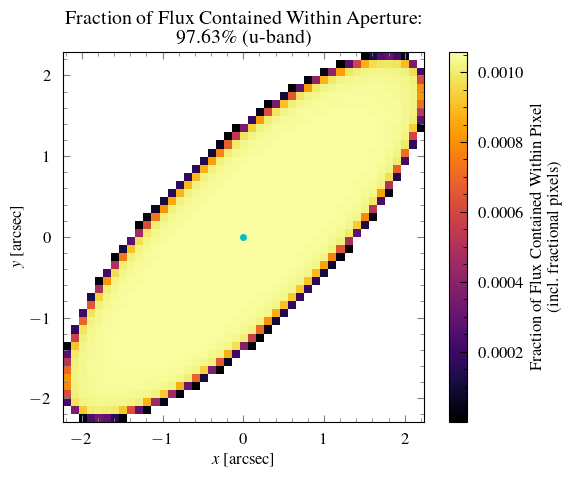

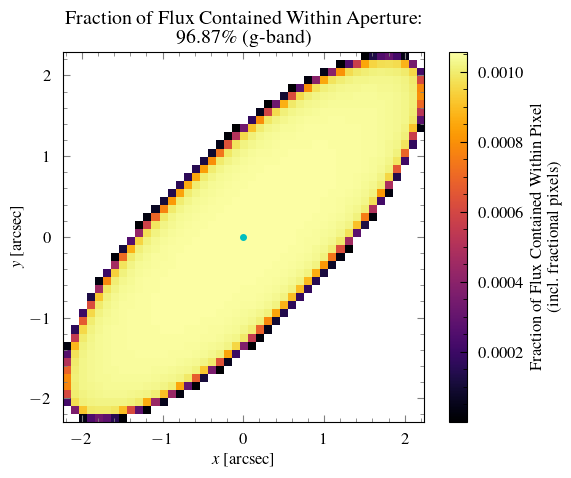

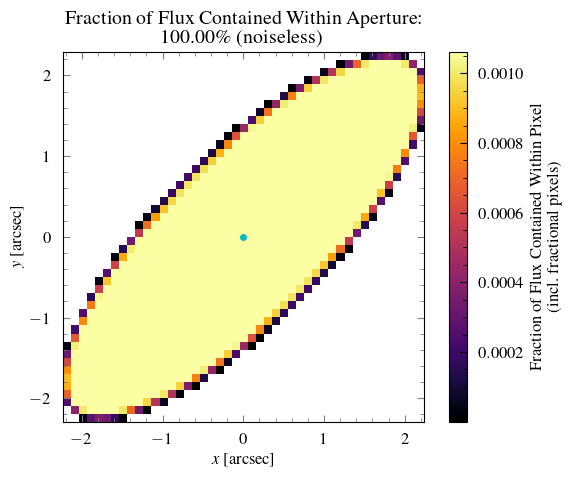

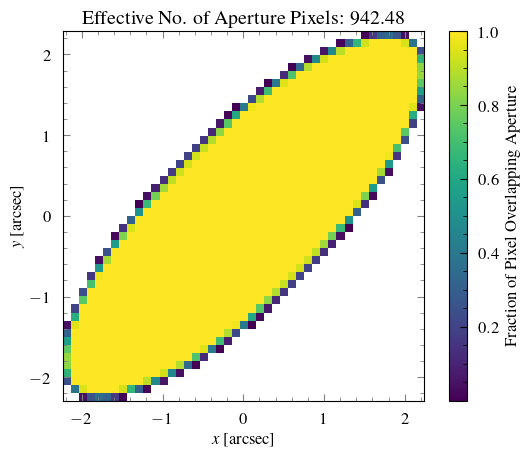

INFO: Fraction of flux within aperture in uv-band = 0.9889258595278716
INFO: Fraction of flux within aperture in u-band = 0.9763362330049656
INFO: Fraction of flux within aperture in g-band = 0.9687343646373412

Time (s) required to reach SNR=10 in uv-band 457928466.7918988
SNR achieved in t=457928466.7918988 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 1103301817364030.5
SNR achieved in t=1103301817364030.5 seconds in u-band 9.999999999999998

Time (s) required to reach SNR=10 in g-band 2094.7720466879614
SNR achieved in t=2094.7720466879614 seconds in g-band 9.999999999999996



In [8]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=3 * u.arcsec, b=1 * u.arcsec, rotation=45)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

If we increase the size of the aperture but keep the entire source enclosed, the fraction
of flux within the noiseless aperture is still 100%, but the time required to reach our
target SNR increases because there are many more background pixels.

Also, the reason why the SNR and integration time calculation below is different from the
corresponding cell in
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb)
is because I fixed a small bug where I was doubly-applying the aperture mask to certain
arrays (like the dark current and sky background noise arrays).


Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


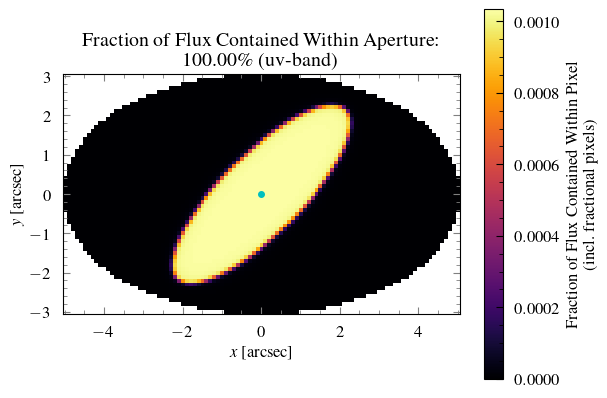

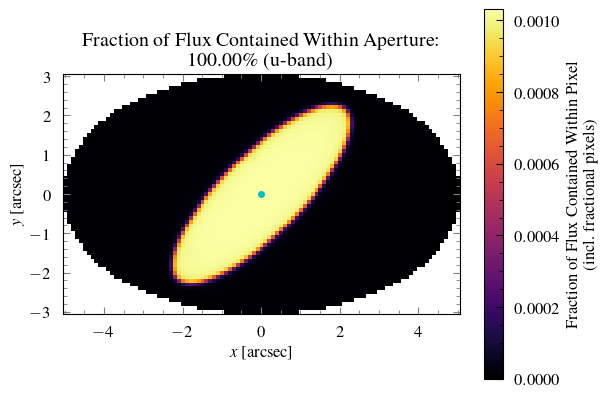

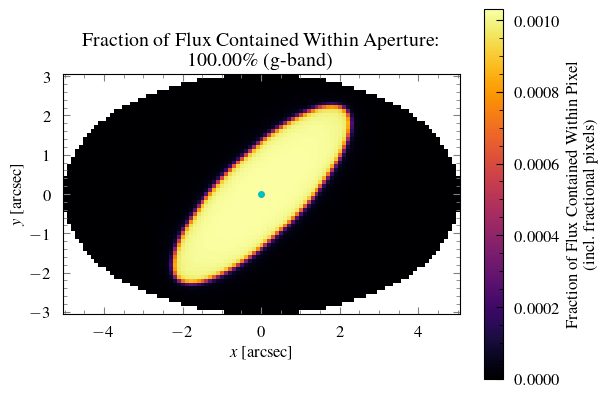

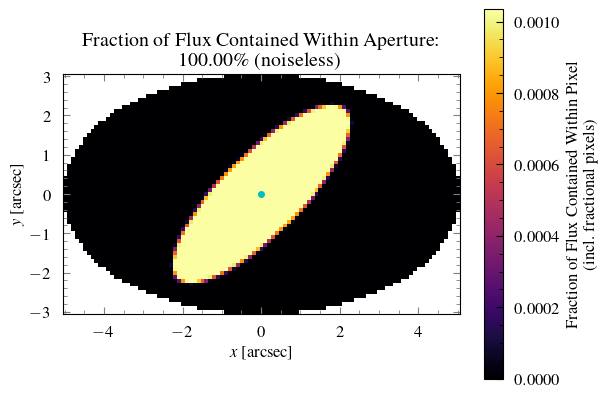

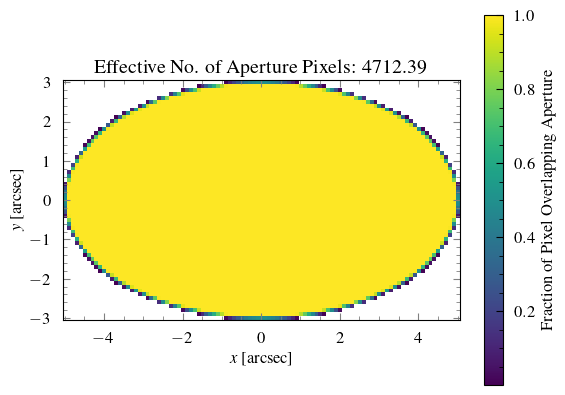

INFO: Fraction of flux within aperture in uv-band = 1.0
INFO: Fraction of flux within aperture in u-band = 1.0
INFO: Fraction of flux within aperture in g-band = 1.0

Time (s) required to reach SNR=10 in uv-band 2238964946.724113
SNR achieved in t=2238964946.724113 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 5258515184890870.0
SNR achieved in t=5258515184890870.0 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 9478.855789029545
SNR achieved in t=9478.855789029545 seconds in g-band 10.0



In [9]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=5 * u.arcsec, b=3 * u.arcsec, rotation=0)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

We can also create an off-centre aperture that is oriented perpendicular to the source
because we are bad astronomers

BTW, the small $<0.3$% difference in the enclosed flux fraction below compared to the same
cell in
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb)
notebook is due to the slightly different way that I am defining the boundary of the
aperture. This doesn't change the total number of aperture pixels, but it does shift the
source within the aperture ever so slightly. The pointing should be more accurate now.

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


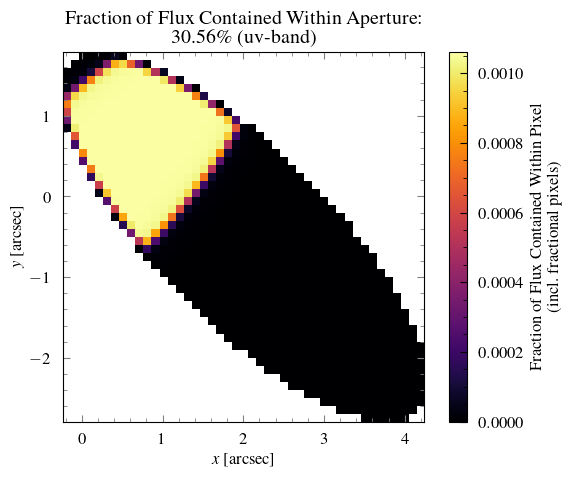

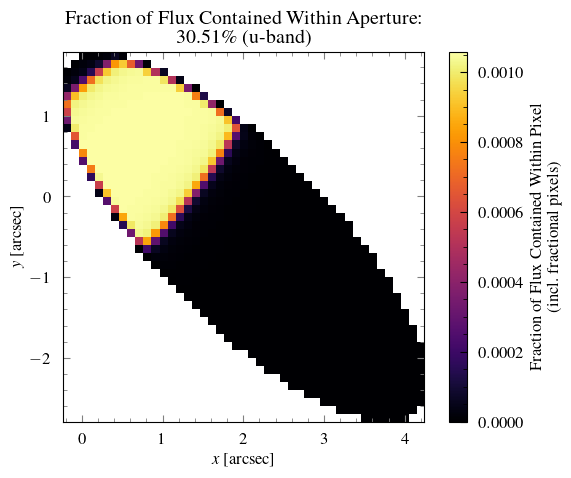

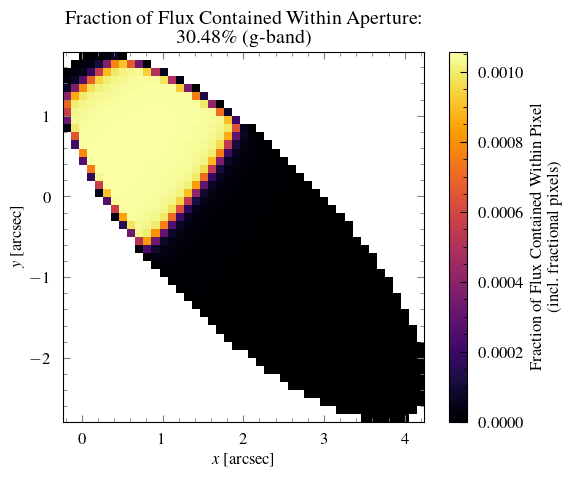

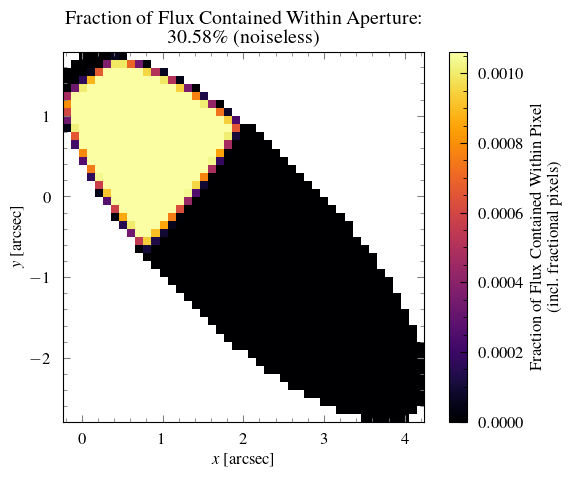

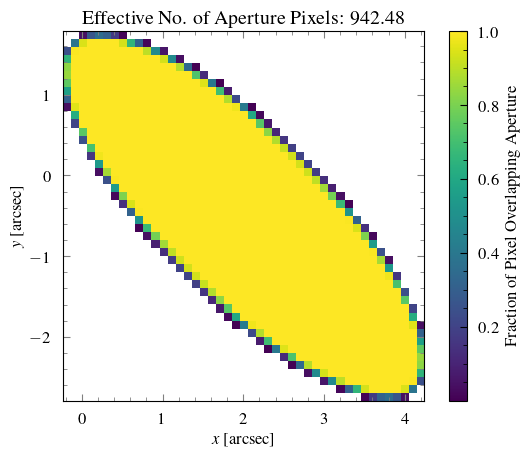

INFO: Fraction of flux within aperture in uv-band = 0.30558982130930384
INFO: Fraction of flux within aperture in u-band = 0.3050512866687224
INFO: Fraction of flux within aperture in g-band = 0.30479279820398697

Time (s) required to reach SNR=10 in uv-band 4795190385.130703
SNR achieved in t=4795190385.130703 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 1.1301794553801788e+16
SNR achieved in t=1.1301794553801788e+16 seconds in u-band 10.000000000000002

Time (s) required to reach SNR=10 in g-band 20407.78248616206
SNR achieved in t=20407.78248616206 seconds in g-band 10.000000000000004



In [10]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=3 * u.arcsec, b=1 * u.arcsec, rotation=135, center=[2, -0.5] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Rectangular aperture examples

### Point source with rectangular aperture

In this case, the default colormap makes it hard to see some of the subtle differences in
the source weights. We will change it to another colormap

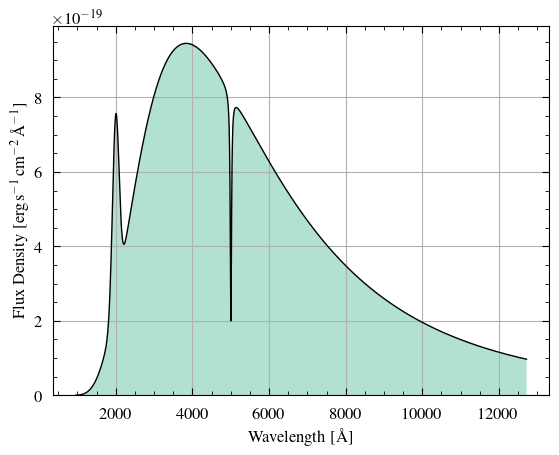

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



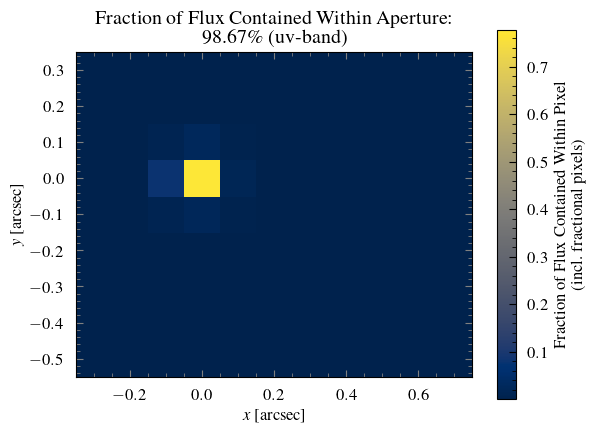

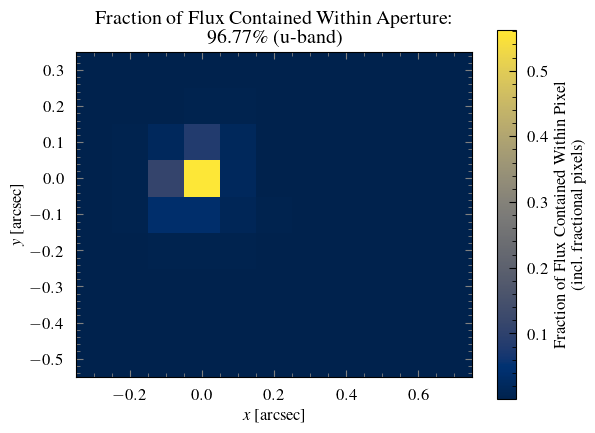

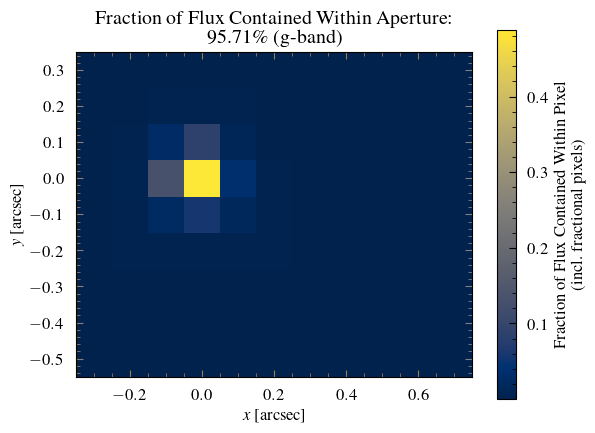

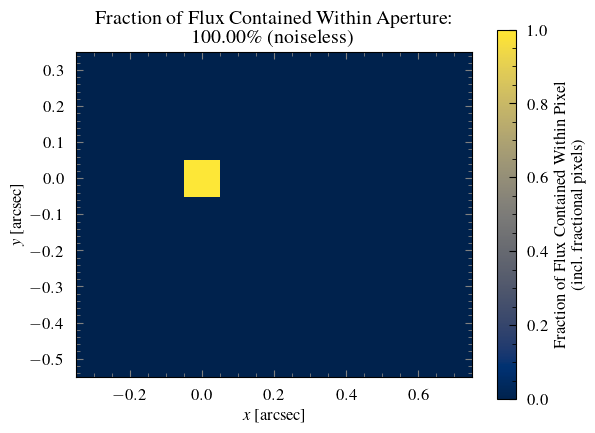

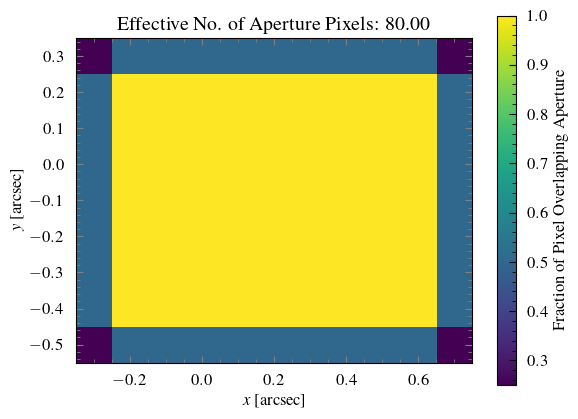

INFO: Fraction of flux within aperture in uv-band = 0.9867196490078626
INFO: Fraction of flux within aperture in u-band = 0.9677223347806961
INFO: Fraction of flux within aperture in g-band = 0.9571369275363569

Time (s) required to reach SNR=10 in uv-band 4583.211505685622
SNR achieved in t=4583.211505685622 seconds in uv-band 9.999999999999996

Time (s) required to reach SNR=10 in u-band 589.9642605027964
SNR achieved in t=589.9642605027964 seconds in u-band 10.000000000000004

Time (s) required to reach SNR=10 in g-band 487.08324985080924
SNR achieved in t=487.08324985080924 seconds in g-band 10.0



In [11]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=1 * u.arcsec, length=0.8 * u.arcsec, center=[0.2, -0.1] * u.arcsec
)

for band in MyPhot.source_weights:
    fig, ax, img, cbar = MyPhot.show_source_weights(band, plot=False)
    img.set_cmap("cividis")
    plt.show()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with rectangular aperture

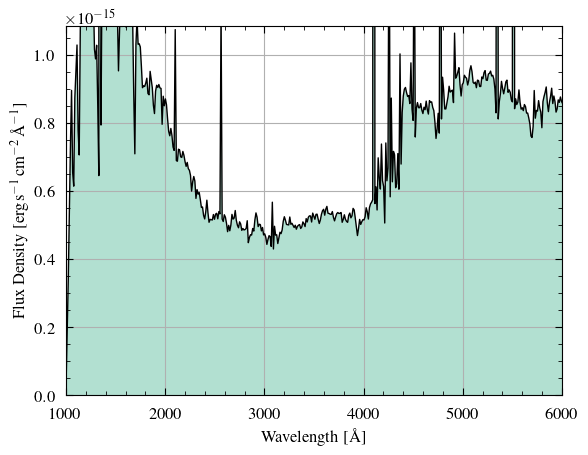

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



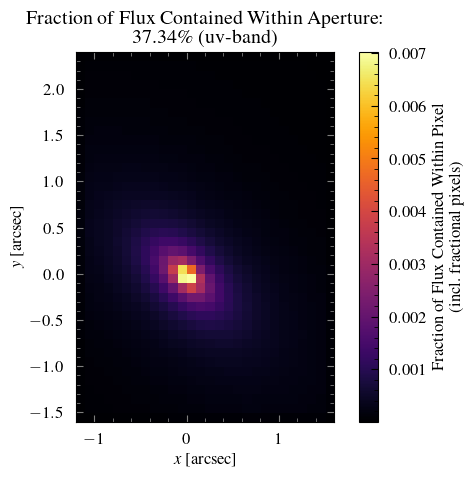

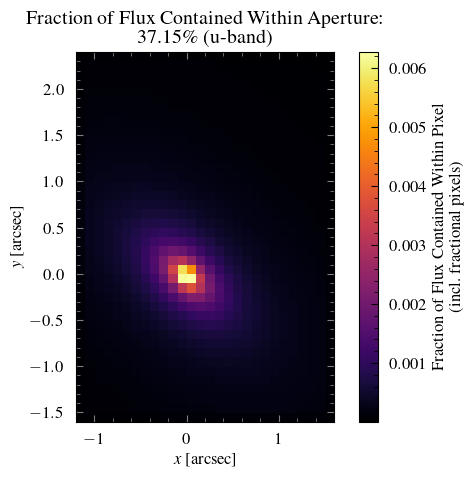

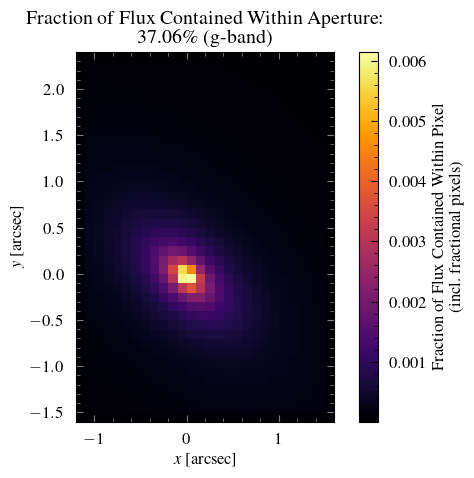

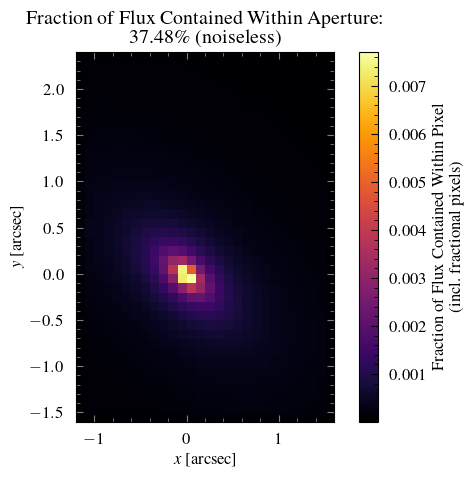

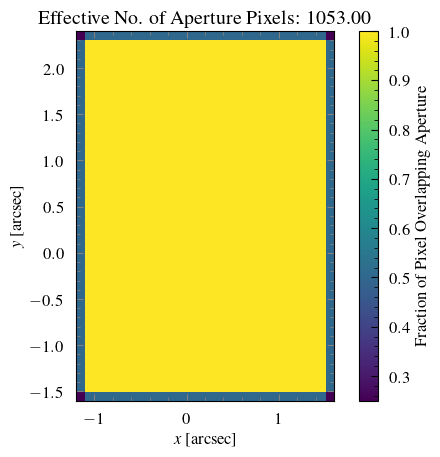

INFO: Fraction of flux within aperture in uv-band = 0.37343712520039374
INFO: Fraction of flux within aperture in u-band = 0.3715446108865834
INFO: Fraction of flux within aperture in g-band = 0.3705648893489448

SNR achieved in t=4321 seconds in uv-band 522.7539787331378
Time (s) required to reach SNR=522.7539787331378 in uv-band 4321.000000000002

SNR achieved in t=4321 seconds in u-band 717.8497479779525
Time (s) required to reach SNR=717.8497479779525 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1552.9918657752373
Time (s) required to reach SNR=1552.9918657752373 in g-band 4321.0



In [12]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=2.7 * u.arcsec, length=3.9 * u.arcsec, center=[0.2, 0.4] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
# fig, ax, cbar = MyPhot.show_source_weights(
#     "noiseless", norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False
# )
# ax.set_title("Same noiseless plot as above but on a log scale")
# plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with rectangular aperture

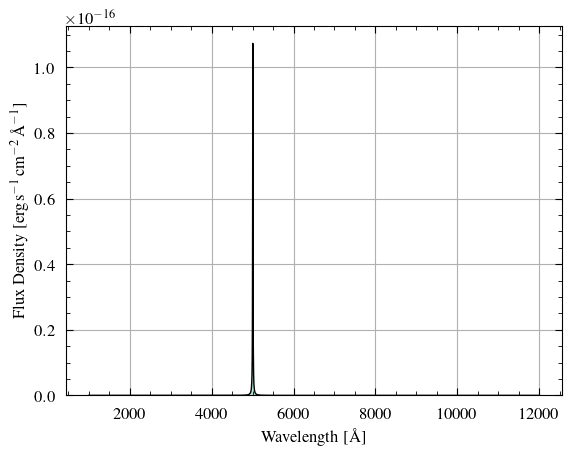

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1372: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


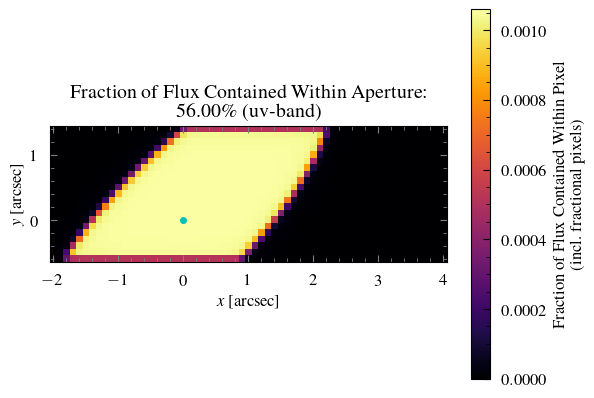

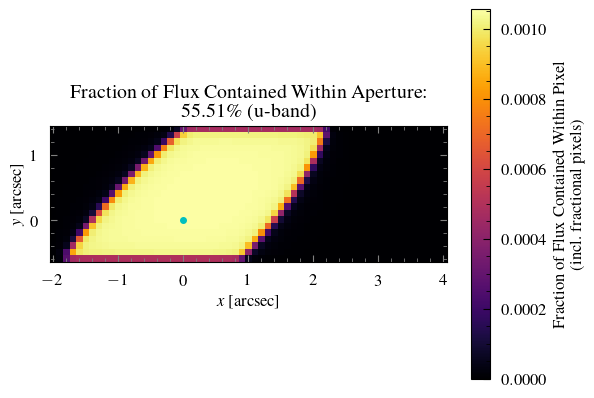

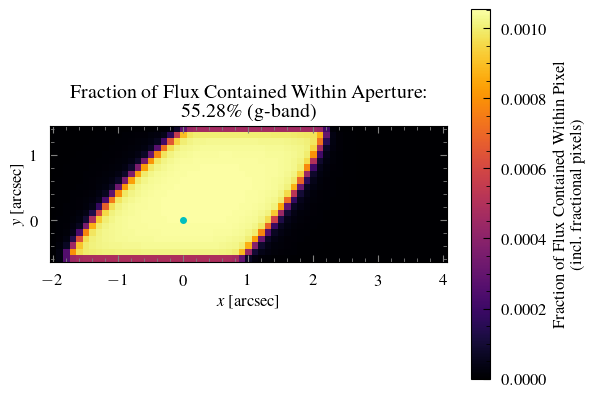

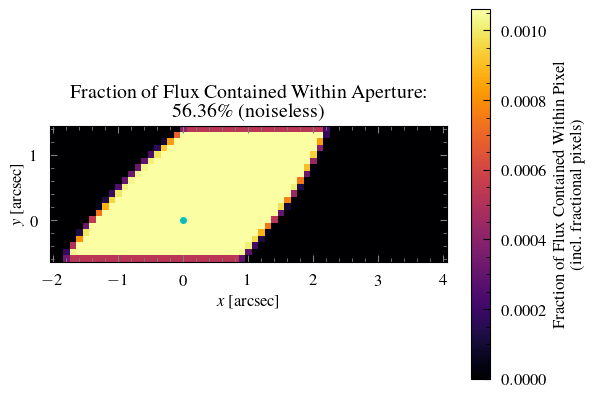

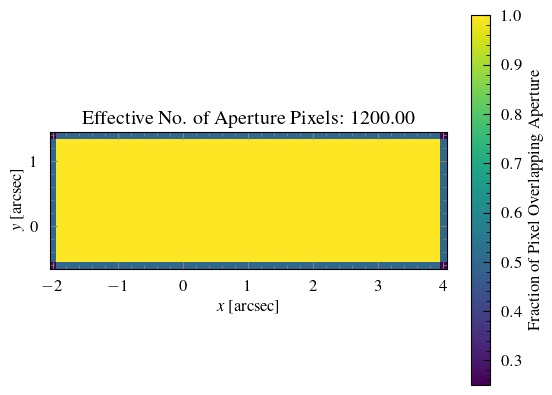

INFO: Fraction of flux within aperture in uv-band = 0.5600042606159578
INFO: Fraction of flux within aperture in u-band = 0.5550844479105247
INFO: Fraction of flux within aperture in g-band = 0.552774077066902

Time (s) required to reach SNR=10 in uv-band 1818106096.7818494
SNR achieved in t=1818106096.7818494 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 4345954079845752.0
SNR achieved in t=4345954079845752.0 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 7954.172525425152
SNR achieved in t=7954.172525425152 seconds in g-band 10.000000000000002



In [13]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=6 * u.arcsec, length=2 * u.arcsec, center=[1, 0.4] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()